In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely
import os.path
import time

from pathlib import Path
from shapely import voronoi_polygons, MultiPoint, unary_union
from shapely.ops import nearest_points
from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords

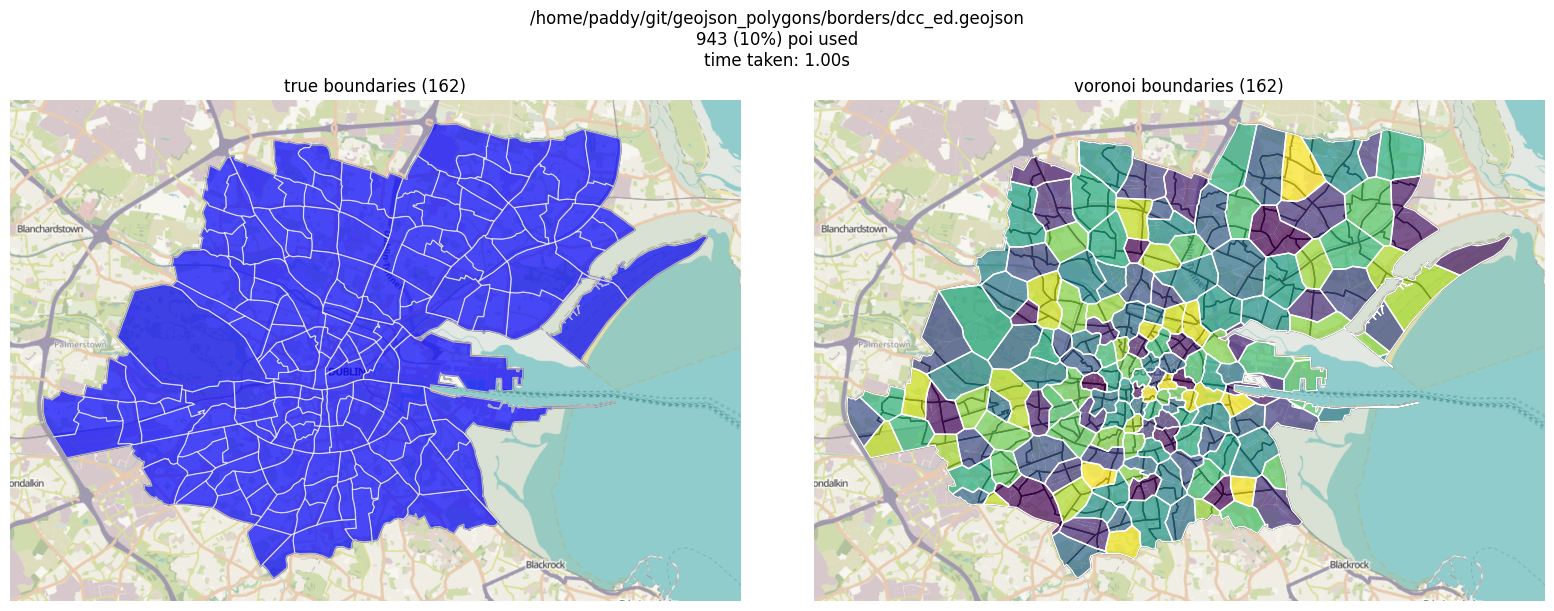

In [3]:



org_dir = "geojson_polygons/dcc.geojson"
poi_dir = "geojson_polygons/geofabrik_dcc_bounding.geojson"

def bound_compare_voronoi(org_dir, poi_dir, epsg=3857, sample=0.1):
    start_time = time.time()
    
    # loading bounds and poi
    org_bounds = gpd.read_file(org_dir).to_crs(epsg)
    org_bounds.geometry = org_bounds.geometry.force_2d()
    poi = gpd.read_file(poi_dir).to_crs(epsg)
    poi = gpd.sjoin(poi, org_bounds)
    poi_sample = round(len(poi)*sample)

    # sampling poi
    poi = poi.sample(poi_sample) if sample < 1 else poi
    if poi_sample < len(org_bounds):
        print(f"poi sample ({poi_sample}) should be > number of original polygons ({len(org_bounds)})")
        print("adjust 'sample' and try again.")
        return
    
    # generating initial voronoi polygons
    boundary_shape = unary_union(org_bounds['geometry'])
    coords = points_to_coords(poi['geometry'])
    region_polys, _ = voronoi_regions_from_coords(coords, boundary_shape)
    poi_vor = gpd.GeoDataFrame(geometry=list(region_polys.values()), crs=epsg)

    # kmeans clustering for new voronoi centroids
    feature_coords = np.array([[e.x, e.y] for e in poi['geometry']])
    kmeans = KMeans(len(org_bounds['geometry']))
    kmeans.fit(feature_coords)
    centroids = kmeans.cluster_centers_
    df = pd.DataFrame(centroids, columns=['x', 'y'])
    poi_clust = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df.x, df.y), crs=3857)

    # classifying constituent voronoi by their distance to cluster centroids
    poi_vor['clust'] = poi_vor.geometry.centroid.apply(lambda g: poi_clust.geometry.distance(g)).apply(np.argmin, axis=1)
    poi_vor_clust = poi_vor.dissolve(by='clust')

    end_time = time.time()

    # plotting
    fig, axs = plt.subplots(1,2,figsize=(16,6), constrained_layout=True)
    fig.suptitle(f"{org_dir}\n{poi_sample} ({int(sample*100)}%) poi used\ntime taken: {end_time - start_time:.2f}s")
    for ax in axs:
        ax.axis('off')
        org_bounds.plot(ax=ax, facecolor='none', edgecolor='black')
        cx.add_basemap(ax, crs=3857, attribution=False)

    axs[0].set_title(f"true boundaries ({len(org_bounds)})")
    org_bounds.plot(ax=axs[0], facecolor='blue', edgecolor='white', alpha=0.7)

    axs[1].set_title(f"voronoi boundaries ({len(poi_vor_clust)})")
    poi_vor.plot(ax=axs[1], edgecolor='none', column='clust', cmap='viridis', alpha=0.7)
    poi_vor_clust.dissolve(by='clust').plot(ax=axs[1], facecolor='none', edgecolor='white')

    plt.show()

    return poi_vor_clust.dissolve(by='clust')

geojson_path = os.path.join(os.path.dirname(os.getcwd()), "geojson_polygons/borders")

dublin_bounds = os.path.join(geojson_path,"dcc_ed.geojson")
dublin_poi = os.path.join(geojson_path,"dublin_poi.geojson")

london_bounds = os.path.join(geojson_path,"london_wards.geojson")
london_poi = os.path.join(geojson_path,"london_poi.geojson")

ireland_bounds = os.path.join(geojson_path,"ireland_counties.geojson")
ireland_poi = os.path.join(geojson_path,"ireland_poi.geojson")

epsg = 3857

#for x in np.linspace(0.1,0.1,1):
dcc_vor_gen = bound_compare_voronoi(dublin_bounds, dublin_poi, epsg, 0.1)

In [4]:
def voronoi_from_points(bounds, points, n):
    # takes in a polygon boundary (single or multi), a collection of points, and generates the appropriate number of Voronoi polygons
    boundary = unary_union(bounds['geometry'])
    coords = points_to_coords(points['geometry'])
    region_polys, _ = voronoi_regions_from_coords(coords, boundary)
    gdf_vor = gpd.GeoDataFrame(geometry=list(region_polys.values()), crs=epsg)

    # kmeans clustering for new voronoi centroids
    feature_coords = np.array([[e.x, e.y] for e in points['geometry']])
    kmeans = KMeans(n)
    kmeans.fit(feature_coords)
    centroids = kmeans.cluster_centers_
    df = pd.DataFrame(centroids, columns=['x', 'y'])
    gdf_clust = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df.x, df.y), crs=3857)

    # classifying constituent voronoi by their distance to cluster centroids
    gdf_vor['clust'] = gdf_vor.geometry.centroid.apply(lambda g: gdf_clust.geometry.distance(g)).apply(np.argmin, axis=1)
    gdf_vor = gdf_vor.dissolve(by='clust')

    return gdf_vor


def poi_voronoi(org_dir, poi_dir, epsg=3857, sample=0.1):    
    org_bounds = gpd.read_file(org_dir).to_crs(epsg)
    org_bounds.geometry = org_bounds.geometry.force_2d()
    poi = gpd.read_file(poi_dir).to_crs(epsg)
    poi = gpd.sjoin(poi, org_bounds)
    poi_sample = round(len(poi)*sample)

    # sampling poi
    poi = poi.sample(poi_sample) if sample < 1 else poi
    if poi_sample < len(org_bounds):
        print(f"poi sample ({poi_sample}) should be > number of original polygons ({len(org_bounds)})")
        print("adjust 'sample' and try again.")
        return
    
    vor_districts = voronoi_from_points(org_bounds, poi, 6)

    return vor_districts
    
    

dublin_bounds = os.path.join(geojson_path,"dcc_ed.geojson")
dublin_poi = os.path.join(geojson_path,"dublin_poi.geojson")
epsg = 3857

poi_vor = poi_voronoi(dublin_bounds, dublin_poi, epsg, 0.1)

X (1500, 1500)
[[ 6  6  6 ...  2  2  2]
 [ 6  6  6 ...  2  2  2]
 [ 6  6  6 ...  2  2  2]
 ...
 [17 17 17 ... 10 10 10]
 [17 17 17 ... 10 10 10]
 [17 17 17 ... 10 10 10]]


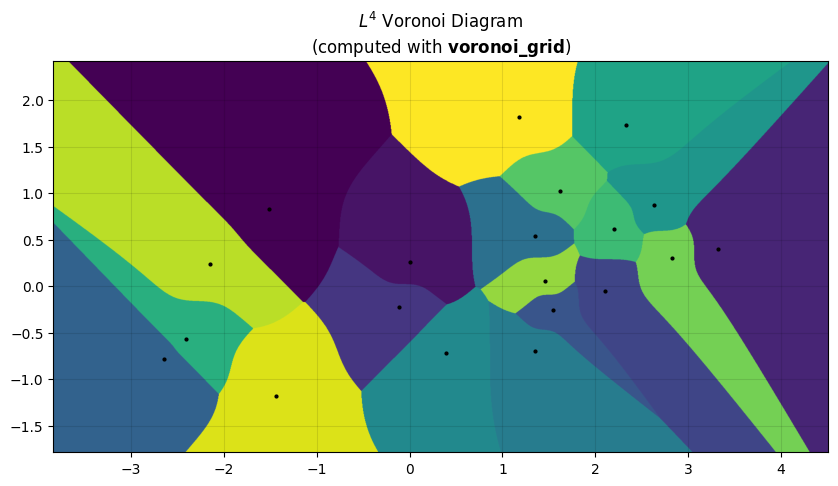

In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import shapely
import os.path
import time

from pathlib import Path
from shapely.ops import nearest_points
from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords

# Copyright © 2021 Warren Weckesser

"""
`voronoi_grid` is for displaying a Voronoi diagram of points in
the plane as an image.
It samples a grid of points and generates an array of integers
that indicate the index in the given `points` array that is
closest to the grid point.  It uses `scipy.spatial.distance.cdist`
to compute the distance, so any metric provided by that function
can be used.  `voronoi_grid` requires SciPy.
"""

import numpy as np
from shapely.geometry import Polygon, MultiPolygon

def voronoi_grid(points, xmin, xmax, ymin, ymax,
                 gridsize=(1000, 1000), **kwds):
    """
    Voronoi diagram visualization grid.

    Create a grid in the bounding box defined by (xmin, xmax, ymin, ymax),
    and for each point in the grid, determine the closest point in `points`.

    The return value is the 2-d array of indices into `points`.

    Additional keyword arguments are passed to scipy.spatial.distance.cdist.

    """
    from scipy.spatial.distance import cdist

    nx, ny = gridsize
    X, Y = np.meshgrid(np.linspace(xmin, xmax, nx),
                       np.linspace(ymin, ymax, ny), indexing='xy')
    
    print("X", X.shape)
    z = np.column_stack((X.ravel(), Y.ravel()))

    dists = cdist(points, z, **kwds)

    lbl = np.argmin(dists, axis=0).reshape(X.shape)
    return lbl

# Create some demo data.
rng = np.random.default_rng(0xb34871f189237a45e445ffb3790c3e1b)
points = rng.multivariate_normal([0, 0], np.diag([5, 1]), size=20)


# Compute values for the bounding box around the points.
# The excess size beyond the data minima and maxima was
# chosen for appearance only.  It can be smaller.
delta = (1/5)*np.ptp(points, axis=0)
xmin, ymin = points.min(axis=0) - delta
xmax, ymax = points.max(axis=0) + delta

img = voronoi_grid(points, xmin, xmax, ymin, ymax,
                   gridsize=(1500, 1500),
                   metric='minkowski', p=4)

print(img)

plt.figure(3, figsize=(10,8))
plt.imshow(img[::-1, :], extent=(xmin, xmax, ymin, ymax))
plt.plot(points[:, 0], points[:, 1], 'k.', markersize=4)
plt.grid(True, color='k', alpha=0.1)
plt.title("$L^4$ Voronoi Diagram\n"
          "(computed with $\\mathtt{\\bf voronoi\\_grid}$)")

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

plt.show()

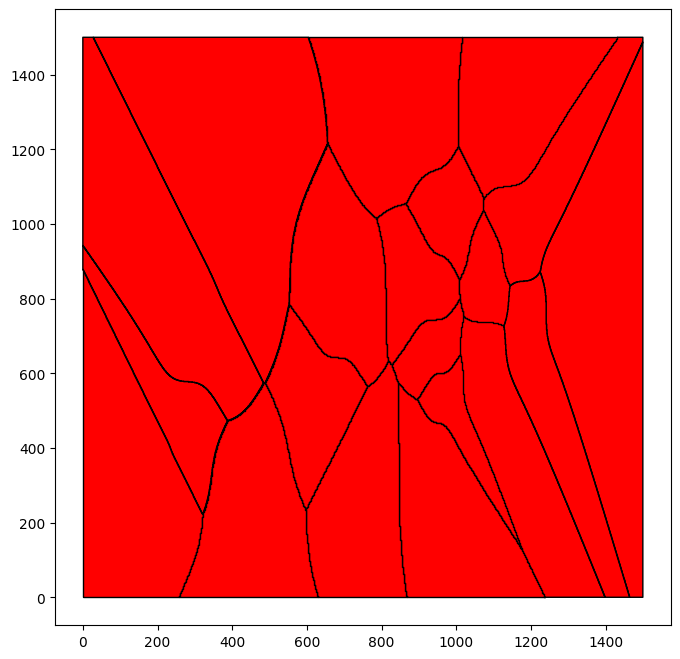

In [6]:
import rasterio.features
import shapely.geometry
import numpy as np



img = img.astype(np.uint8)

shapes = [item for item in rasterio.features.shapes(img)]

polys = gpd.GeoSeries([])
for x in list(np.unique(img)):
    current_poly = gpd.GeoSeries([shapely.geometry.Polygon(shape[0]["coordinates"][0]) for shape in shapes if shape[1] == x])
    polys = pd.concat([polys.geometry, current_poly.geometry])

gdf = gpd.GeoDataFrame(geometry=polys.geometry, crs=3857)


fig, ax = plt.subplots(1,1, figsize=(10,8))

gdf.plot(ax=ax, edgecolor='black', facecolor='red')

plt.show()



normal voronoi                                             geometry
0  MULTIPOLYGON (((-719144.668 7054736.161, -7049...
clipped voronoi                                             geometry
0  POLYGON ((-697917.227 7055347.575, -695135.042...


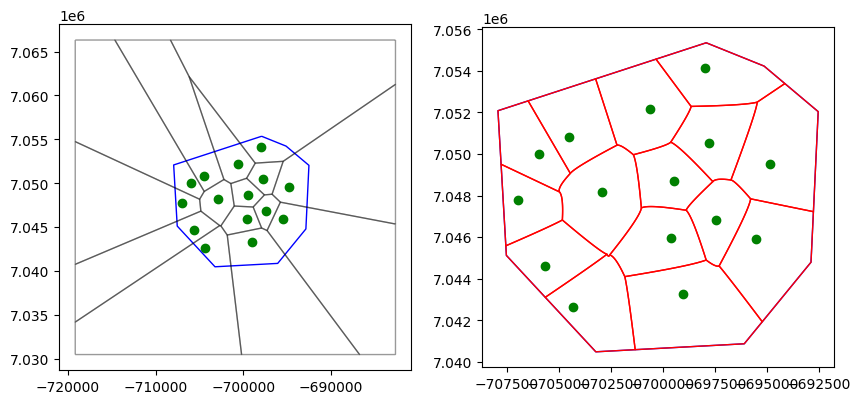

In [7]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
from shapely import affinity
import random
from shapely.geometry import Polygon, MultiPolygon, MultiPoint, Point, LineString
from line_bender import LineStringBender

def flatten(xss):
    return [x for xs in xss for x in xs]

dv_points = gpd.read_file('dublin_vor_points.geojson').to_crs(3857)
dcc = gpd.read_file('dublin_vor.geojson').to_crs(3857)

centre = dcc.centroid[0]
bounds = dcc.bounds

test_point = dv_points.geometry[0]

for i, point in enumerate(dv_points.geometry):
    dv_points = dv_points.join(pd.DataFrame({f'{i}' : dv_points.distance(point, 'left')}))

dist_matrix = np.asarray(dv_points.drop('geometry', axis=1))
min_dists = [np.min(row[np.nonzero(row)]) for row in dist_matrix]
min_dists_half = [np.min(row[np.nonzero(row)])/2 for row in dist_matrix]

def bez_warp_multi(multishape, rel_dist=[0.1,0.2], off_dist=[100,200]):
    multi_edges = flatten([[LineString(poly.boundary.coords[k:k+2]) for k in range(len(poly.boundary.coords) - 1)] for poly in multishape.geoms])
    
    uni_edges = []
    for edge in multi_edges:
        if not any(e.equals(edge) for e in uni_edges):
            uni_edges.append(edge)

    out_list = []
    for edge in uni_edges:
        edge_bez = LineStringBender(edge, random.uniform(rel_dist[0],rel_dist[1]), random.uniform(off_dist[0],off_dist[1]), 'left').smooth_curve_geom()
        out_list.append(edge_bez)
    return shapely.polygonize(out_list).geoms

dl_tri = dv_points.delaunay_triangles()

dv_vor = MultiPolygon([shape for shape in shapely.voronoi_polygons(MultiPoint(dv_points.geometry)).geoms])

dv_vor_bez = bez_warp_multi(dv_vor)

dv_vor = gpd.GeoDataFrame(geometry=gpd.GeoSeries(dv_vor))#.clip(dcc.geometry[0]))
dv_vor_bez = gpd.GeoDataFrame(geometry=gpd.GeoSeries(dv_vor_bez))#.clip(dcc.geometry[0]))

print("normal voronoi", dv_vor)
print("clipped voronoi", dv_vor.clip(dcc.geometry[0], keep_geom_type=True))

fig, axs = plt.subplots(1,2, figsize=(10,8))

dcc.plot(ax=axs[0], facecolor='none', edgecolor='blue')
dcc.plot(ax=axs[1], facecolor='none', edgecolor='blue')

dv_vor.plot(ax=axs[0], edgecolor='black', facecolor='none', alpha=0.4)
dv_vor_bez.clip(dcc.geometry[0]).plot(ax=axs[1], edgecolor='red', facecolor='none')
dv_points.plot(ax=axs[0], color='green')
dv_points.plot(ax=axs[1], color='green')

plt.show()

In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
from shapely import affinity
import random
from shapely.geometry import Polygon, MultiPolygon, MultiPoint, Point, LineString, MultiLineString
from line_bender import LineStringBender

def flatten(xss):
    return [x for xs in xss for x in xs]

dv_points = gpd.read_file('dublin_vor_points.geojson').to_crs(3857)
dcc = gpd.read_file('dublin_vor.geojson').to_crs(3857)

def voronoi_n(bounds, points, n):
    # takes in a polygon boundary (single or multi), a collection of points, and generates the appropriate number of Voronoi polygons
    boundary = unary_union(bounds['geometry'])
    
    # kmeans clustering for new voronoi centroids
    feature_coords = np.array([[e.x, e.y] for e in points['geometry']])
    kmeans = KMeans(n)
    kmeans.fit(feature_coords)
    centroids = kmeans.cluster_centers_
    df = pd.DataFrame(centroids, columns=['x', 'y'])
    gdf_clust = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df.x, df.y), crs=3857)

    coords = points_to_coords(gdf_clust['geometry'])
    region_polys, _ = voronoi_regions_from_coords(coords, boundary.envelope) #.envelope
    gdf_vor = gpd.GeoDataFrame(geometry=list(region_polys.values()), crs=epsg)

    return gdf_vor


def poi_voronoi_n(org_dir, poi_dir, epsg=3857, sample=0.1, n=5):    
    org_bounds = gpd.read_file(org_dir).to_crs(epsg)
    org_bounds.geometry = org_bounds.geometry.force_2d()
    poi = gpd.read_file(poi_dir).to_crs(epsg)
    poi = gpd.sjoin(poi, org_bounds)
    poi_sample = round(len(poi)*sample)

    # sampling poi
    poi = poi.sample(poi_sample) if sample < 1 else poi
    if poi_sample < len(org_bounds):
        print(f"poi sample ({poi_sample}) should be > number of original polygons ({len(org_bounds)})")
        print("adjust 'sample' and try again.")
        return
    
    vor_districts = voronoi_n(org_bounds, poi, n)

    return vor_districts
    

def to_poly(geosrs):
    poly_out = []
    for poly in geosrs:
        if isinstance(poly, MultiPolygon):
            _ = [poly_out.append(geom) for geom in poly.geoms]
        else:
            poly_out.append(poly)
    return gpd.GeoSeries(poly_out)
    #return gpd.GeoSeries([shapely.make_valid(poly) if isinstance(poly, Polygon) else [shapely.make_valid(geom) for geom in poly.geoms] for poly in geosrs])

def bez_warp_multi_gdf(multigeom, rel_dist=[0.5,0.5], off_dist=[1,10], prob=1):
    # Taking in GeoSeries as input for multigeom    
    multigeom = to_poly(multigeom)

    multi_edges = flatten([[LineString(poly.boundary.coords[k:k+2]) for k in range(len(poly.boundary.coords) - 1)] for poly in multigeom])
    
    print(len(multi_edges))

    uni_edges = []
    for edge in multi_edges:
        if not any(e.equals(edge) for e in uni_edges):
            uni_edges.append(edge)

    print("polygonized unique edges:", len(gpd.GeoSeries(shapely.polygonize(uni_edges).geoms)))
    
    out_list = []
    for edge in uni_edges:
        if prob < 1:
            chance = random.uniform(0,1)
            if prob > chance:
                edge_bez = LineStringBender(edge, random.uniform(rel_dist[0],rel_dist[1]), random.uniform(edge.length/10,2*edge.length/10), random.choice(['right','left'])).smooth_curve_geom()
            else:
                edge_bez = edge
        else:
            edge_bez = LineStringBender(edge, random.uniform(rel_dist[0],rel_dist[1]), random.uniform(edge.length/10,2*edge.length/10), random.choice(['right','left'])).smooth_curve_geom()
        out_list.append(edge_bez)

    return gpd.GeoDataFrame(geometry=gpd.GeoSeries(out_list), crs=3857)
    #return gpd.GeoSeries(shapely.polygonize(out_list).geoms)

dublin_bounds = os.path.join(geojson_path,"dcc_ed.geojson")
dublin_poi = os.path.join(geojson_path,"dublin_poi.geojson")
epsg = 3857

poi_vor_n = poi_voronoi_n(dublin_bounds, dublin_poi, epsg, 0.1, 160)

dcc = gpd.read_file(dublin_bounds).to_crs(3857)


boundary = dcc.dissolve()
gdf_bez = bez_warp_multi_gdf(poi_vor_n.geometry, rel_dist=[0.25,0.75], off_dist=[1000,1000], prob=0.5)

print(gdf_bez)

#gdf_bez = gpd.GeoDataFrame(geometry=bez_warp_multi_gdf(dcc.geometry, rel_dist=[0.25,0.75], off_dist=[100,200]), crs=3857)

#gdf_bez_new = gpd.overlay(gdf_bez, boundary, how='union').clip(boundary.geometry[0]).reset_index(drop=True)
gdf_bez_new = gdf_bez.clip(boundary.geometry[0]).reset_index(drop=True)

937
polygonized unique edges: 160
                                              geometry
0    LINESTRING (-684643.751 7059342.331, -680552.7...
1    LINESTRING (-680552.712 7059342.331, -680552.7...
2    LINESTRING (-680397.167 7059342.331, -680397.1...
3    LINESTRING (-680397.167 7059195.429, -680397.1...
4    LINESTRING (-680397.167 7056299.039, -683374.7...
..                                                 ...
478  LINESTRING (-697095.295 7047520.955, -697054.9...
479  LINESTRING (-697672.778 7047147.374, -697672.7...
480  LINESTRING (-697249.145 7046754.109, -697749.8...
481  LINESTRING (-696865.356 7046967.714, -696555.4...
482  LINESTRING (-697107.572 7046747.972, -697107.7...

[483 rows x 1 columns]


total length: 438
linestrings: 422
multilinestrings: 13


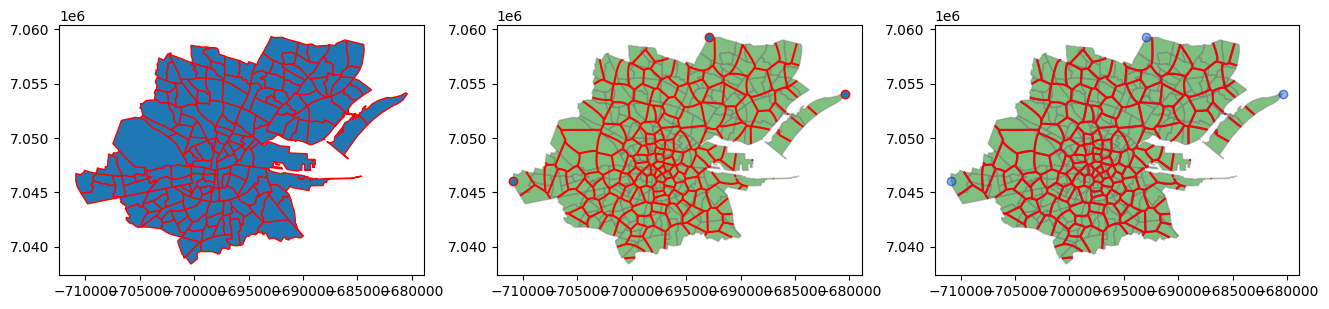

In [9]:
fig, axs = plt.subplots(1,3, figsize=(16,10))

dcc.plot(ax=axs[0], edgecolor='red')
dcc.plot(ax=axs[1], facecolor='green', edgecolor='grey', alpha=0.5)
dcc.plot(ax=axs[2], facecolor='green', edgecolor='grey', alpha=0.5)


gdf_bez_new.plot(ax=axs[1], edgecolor='red')
gdf_bez_new.plot(ax=axs[2], edgecolor='blue', alpha=0.5)

print("total length:", len(gdf_bez_new))
print("linestrings:", len(gdf_bez_new[gdf_bez_new.geom_type == 'LineString']))
print("multilinestrings:", len(gdf_bez_new[gdf_bez_new.geom_type == 'MultiLineString']))

lines = MultiLineString([line for line in gdf_bez_new[(gdf_bez_new.geom_type == 'LineString') | (gdf_bez_new.geom_type == 'MultiLineString')].geometry.explode()])

#lines = MultiLineString([line for line in gdf_bez_new[gdf_bez_new.geom_type == 'LineString' | gdf_bez_new.geom_type == 'LineString'].geometry])
lines_geo = gpd.GeoSeries(lines)
lines_geo.plot(ax=axs[2], edgecolor='red')

bound_line = boundary.boundary[0]
union = shapely.ops.unary_union([bound_line, lines])
split_polygons = gpd.GeoSeries(list(shapely.ops.polygonize(union)))
plt.show()

<Axes: title={'center': 'warped voronoi (155)'}>

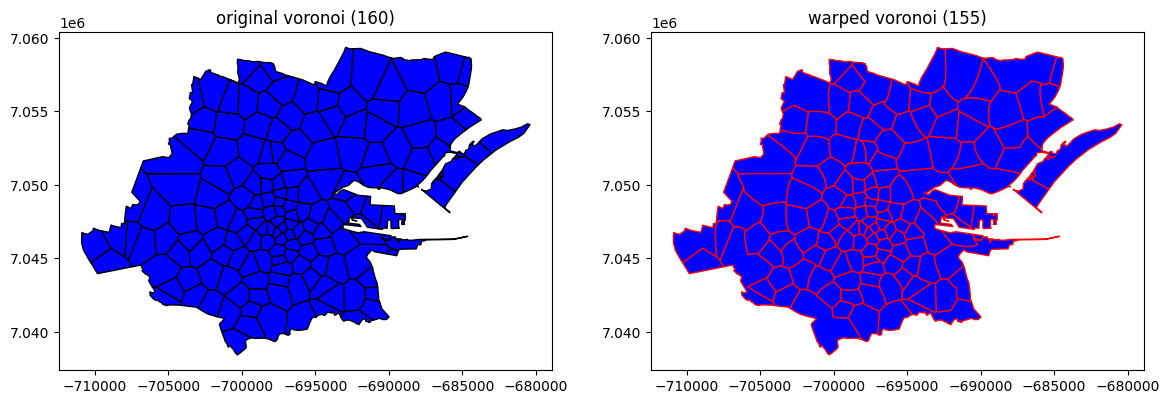

In [10]:
org_vor = poi_vor_n.clip(boundary.geometry[0]).reset_index(drop=True)

fig, axs = plt.subplots(1,2,figsize=(14,10))

axs[0].set_title(f"original voronoi ({len(org_vor)})")
org_vor.plot(ax=axs[0], edgecolor='black', facecolor='blue')

axs[1].set_title(f"warped voronoi ({len(split_polygons)})")
split_polygons.plot(ax=axs[1], edgecolor='red', facecolor='blue')

In [11]:
missing_poly = len(org_vor) - len(split_polygons)
print("missing polygons:", missing_poly)
test_gdf = gpd.GeoDataFrame(geometry=split_polygons, crs=3857)
test_gdf['area'] = split_polygons.area
test_gdf = test_gdf.sort_values(by=['area'], ascending=False).reset_index(drop=True)

def points_uniform(poly, num_points):
    min_x, min_y, max_x, max_y = poly.total_bounds
    
    points = []
    # Generates points repeatedly with a uniform generation within the bounds of the polygon
    while len(points) < num_points * 2:
        points.append(Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)]))

    gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(points), crs=3857)
    gdf = gdf.sjoin(poly, predicate='within')
    gdf = gdf.drop(['index_right'], axis=1)

    return gdf.iloc[0:num_points].reset_index(drop=True)


def vor_n(bounds, points, n):
    # takes in a polygon boundary (single or multi), a collection of points, and generates the appropriate number of Voronoi polygons
    boundary = unary_union(bounds)

    # kmeans clustering for new voronoi centroids
    feature_coords = np.array([[e.x, e.y] for e in points['geometry']])
    kmeans = KMeans(n)
    kmeans.fit(feature_coords)
    centroids = kmeans.cluster_centers_
    voronoi_test = gpd.GeoSeries(shapely.voronoi_polygons(MultiPoint([Point(coords) for coords in centroids])).geoms)
    return voronoi_test

def split_poly(poly, n):
    pts = points_uniform(poly,100)
    vor = vor_n(poly.geometry[0], pts, n)
    return vor



missing polygons: 5


<Axes: >

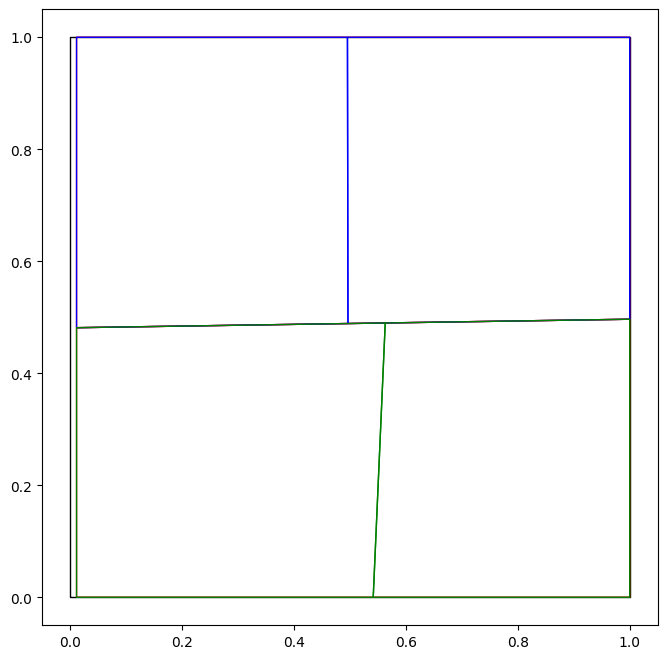

In [12]:
import random

def points_uniform(poly, num_points):
    min_x, min_y, max_x, max_y = poly.total_bounds
    
    points = []
    # Generates points repeatedly with a uniform generation within the bounds of the polygon
    while len(points) < num_points * 2:
        points.append(Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)]))

    

    return gdf.iloc[0:num_points].reset_index(drop=True)

def voronoi_split(poly, n):
    if not isinstance(poly, gpd.GeoDataFrame):
        poly = gpd.GeoDataFrame(geometry=gpd.GeoSeries(poly), crs=3857)
    min_x, min_y, max_x, max_y = poly.total_bounds
    
    points = []
    # Generates points repeatedly with a uniform generation within the bounds of the polygon
    while len(points) < 100 * 2:
        points.append(Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)]))

    gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(points), crs=3857)
    gdf = gdf.sjoin(poly, predicate='within')
    gdf = gdf.drop(['index_right'], axis=1)

    # takes in a polygon boundary (single or multi), a collection of points, and generates the appropriate number of Voronoi polygons
    boundary = unary_union(poly)

    # kmeans clustering for new voronoi centroids
    feature_coords = np.array([[e.x, e.y] for e in gdf['geometry']])
    kmeans = KMeans(n)
    kmeans.fit(feature_coords)
    centroids = kmeans.cluster_centers_
    voronoi_out = gpd.GeoSeries(shapely.voronoi_polygons(MultiPoint([Point(coords) for coords in centroids])).geoms).clip(boundary)

    join = gpd.GeoSeries(shapely.intersection(voronoi_out.geometry[0], voronoi_out.geometry[1]))#.geometry[0]
    #join_bez_a = gpd.GeoSeries(LineStringBender(join, random.uniform(0.4,0.6), random.uniform(join.length/10,2*join.length/10), random.choice(['right','left'])).smooth_curve_geom())
    
    return voronoi_out, join

square = gpd.GeoSeries(shapely.Polygon([(0,0), (0,1), (1,1), (1,0)]))

split_square, split_warp = voronoi_split(square, 2)

quart_ab, ab_split = voronoi_split(split_square[0], 2)
quart_cd, cd_split = voronoi_split(split_square[1], 2)

fig, ax = plt.subplots(1,1,figsize=(10,8))

square.plot(ax=ax, edgecolor='black', facecolor='none')
split_square.plot(ax=ax, edgecolor='red', facecolor='none')
quart_ab.plot(ax=ax, edgecolor='blue',facecolor='none')
quart_cd.plot(ax=ax, edgecolor='green', facecolor='none')
#split_warp.plot(ax=ax, edgecolor='green')

/home/paddy/miniconda3/envs/bezier/lib/python3.12/site-packages/geopandas/geoseries.py:1520: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:3857

  return geopandas.clip(self, mask=mask, keep_geom_type=keep_geom_type, sort=sort)
/home/paddy/miniconda3/envs/bezier/lib/python3.12/site-packages/geopandas/geoseries.py:1520: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:3857

  return geopandas.clip(self, mask=mask, keep_geom_type=keep_geom_type, sort=sort)


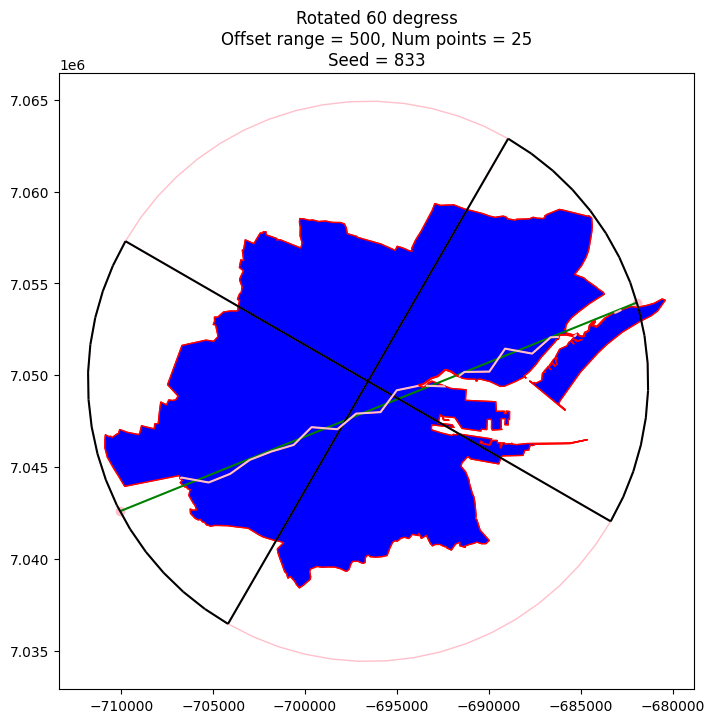

In [13]:
from shapely.ops import split, snap, linemerge, polygonize
from itertools import combinations
from random import randint

def find_overlaps(gdf):
    """Returns a list of tuples identifying the geometries
    that overlap one another.
    """
    overlaps, retouch = [], {}
    for x, y in combinations(gdf.index.tolist(), 2):
        g_x = gdf.loc[x].geometry
        g_y = gdf.loc[y].geometry
        if g_x.intersects(g_y):
            overlaps.append([x, y])

    for t, b in overlaps:
        retouch.setdefault(t, []).append(b)

    return overlaps, retouch


def clip_overlaps_by_weight(gdf, col, tol=0.0000001):
    """Clips out overlapping geometries within a shapefile
    ranked by an attribute.
    """

    gdf.sort_values(by=col, axis=0, ascending=False, inplace=True)
    gdf.reset_index(drop=True,inplace=True)
    dupd = gdf.geometry.duplicated()
    if dupd.any():  # keep highest weighted duplicate, remove the rest
        gdf = gdf.loc[~dupd]

    overlaps, retouch = find_overlaps(gdf)

    for overlap in overlaps:
        top, bot = gdf.loc[overlap].geometry
        try:
            bot = bot.difference(top)
        except:
            breakpoint()
        top = snap(top, bot, tol)
        gdf.loc[overlap, "geometry"] = gpd.GeoSeries([top, bot], index=overlap)

    for clipper, clip_list in retouch.items():
        for clipped in clip_list[:-1]:
            top, bot = gdf.loc[[clipper, clipped]].geometry
            gdf.loc[clipped, "geometry"] = snap(bot, top, tol)

    return gdf.reset_index(drop=True)

def n_radial(n, poly, rot=0):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0])/2
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    a = Point([poly.centroid.x, poly.centroid.y+(poly_r*1.2)])
    lines = [LineString([poly_c,[a.x, a.y]])]
    vertices = [a]
    for i in range(n):
        vert_rotate = affinity.rotate(a, (360/n)*(i+1), origin=poly_c)
        vertices.append(vert_rotate)
        lines.append(LineString([poly_c, [vert_rotate.x, vert_rotate.y]]))

    return gpd.GeoDataFrame({'geometry' : lines}, geometry='geometry', crs=3857)

def radial_split(polygon, n=5, rot=0):
    #polygon = gpd.GeoSeries(polygon)
    # calculate centre and radius of input polygon
    polygon_r = (polygon.bounds.maxx[0] - polygon.bounds.minx[0])/2

    # generate buffers and remove overlapping areas
    buffer = polygon.centroid.buffer(polygon_r)
    
    lines = n_radial(n, buffer, rot)
    points = [[point for point in line.coords] for line in lines.geometry[:]]
    merge_line = LineString([val for sublist in points for val in sublist])
    # divide the buffers using the radial linestring and return

    ring_split = affinity.rotate(split(buffer.geometry[0], merge_line), rot, origin='centroid')    
    return gpd.GeoSeries(ring_split.geoms)

def warped_line(line, points, offset_dist):
    endpoint_a, endpoint_b = line.interpolate(0, normalized=True), line.interpolate(1,normalized=True)
    inter_marks = np.linspace(0,1, points)[1:-1]
    inter_points = [line.offset_curve(random.uniform(-offset_dist, offset_dist)).interpolate(x, normalized=True) for x in inter_marks]
    inter_points.insert(0,endpoint_a)
    inter_points.append(endpoint_b)
    return LineString(inter_points)

def cut_polygon_by_line(polygon, line):
    merged = linemerge([polygon.boundary, line])
    borders = unary_union(merged)
    polygons = polygonize(borders)
    return gpd.GeoSeries(list(polygons))


square = gpd.GeoSeries(shapely.Polygon([(0,0), (0,1), (1,1), (1,0)]))

def warped_poly_split(poly_in, offset_range=0.01, points_num=25, angle=0, seed=None):
    if isinstance(seed, int):
        random.seed(seed)
    else:
        random.seed(random.randint(0,10**6))

    poly_radial = radial_split(poly_in, 4, angle)

    join_list = []
    for poly in poly_radial:
        join_list.append(shapely.intersection(poly, poly.boundary))
    join_gs = gpd.GeoSeries(join_list)

    alpha = join_gs[1].line_interpolate_point(random.uniform(0.1, 0.3), normalized=True)
    beta = join_gs[3].line_interpolate_point(random.uniform(0.1, 0.3), normalized=True)
    
    alphabeta = LineString([alpha,beta])
    line_warp = warped_line(alphabeta, points_num, offset_range)

    fig, ax = plt.subplots(1,1,figsize=(10,8))
    ax.set_title(f"Rotated {angle} degress\nOffset range = {offset_range}, Num points = {points_num}\nSeed = {seed}")

    poly_test = cut_polygon_by_line(poly_in.geometry[0], line_warp).clip(poly_in)

    gpd.GeoSeries(alphabeta).plot(ax=ax, edgecolor='green', facecolor='none')
    gpd.GeoSeries(join_gs[1]).plot(ax=ax, edgecolor='black')
    gpd.GeoSeries(join_gs[3]).plot(ax=ax, edgecolor='black')
    gpd.GeoSeries([alpha, beta]).plot(ax=ax, color='pink')
    gpd.GeoSeries(line_warp).clip(poly_in).plot(ax=ax, color='pink')
    poly_in.plot(ax=ax, edgecolor='red', facecolor='none')
    poly_test.plot(ax=ax, edgecolor='red', facecolor='blue')
    poly_radial.plot(ax=ax, edgecolor='pink', facecolor='none')
    plt.show()

dcc_test = dcc.dissolve()
## Problem Seeds
## 443
warped_poly_split(dcc_test, offset_range=500, points_num=25, angle=60, seed=random.randint(0,1000))



<Axes: >

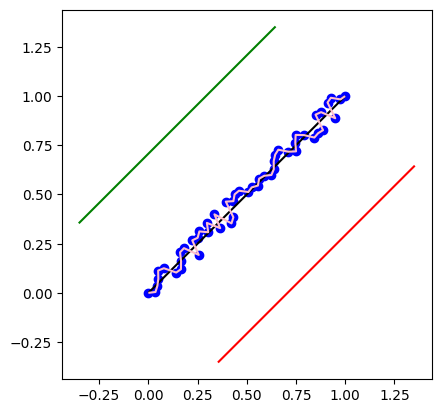

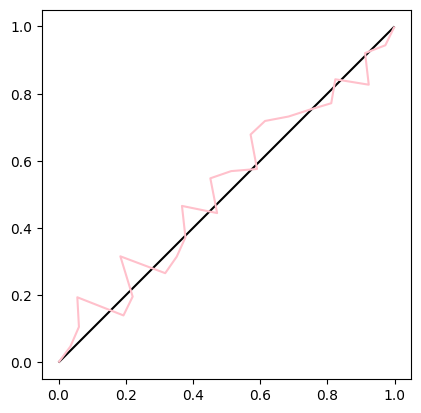

In [14]:
point_a = Point([0,0])
point_b = Point([1,1])
line_ab = LineString([point_a, point_b])

max_dist = 0.05

num_points = 50

line_inters = np.linspace(0, 1, num=num_points)[1:-1]

# needs to keep the original end points of the line to ensure continuity
inters = [line_ab.offset_curve(random.uniform(-max_dist, max_dist)).interpolate(x, normalized=True) for x in line_inters]

inters.insert(0, point_a)
inters.append(point_b)


inters_line = LineString(inters)

line_offset_a = line_ab.offset_curve(0.5)
line_offset_b = line_ab.offset_curve(-0.5)

def warped_line(line, points, offset_dist):
    endpoint_a, endpoint_b = line.interpolate(0, normalized=True), line.interpolate(1,normalized=True)
    inter_marks = np.linspace(0,1, points)[1:-1]
    inter_points = [line.offset_curve(random.uniform(-offset_dist, offset_dist)).interpolate(x, normalized=True) for x in inter_marks]
    inter_points.insert(0,endpoint_a)
    inter_points.append(endpoint_b)
    return LineString(inter_points)



fig, ax = plt.subplots()

gpd.GeoSeries(line_ab).plot(ax=ax, color='black')
gpd.GeoSeries(line_offset_a).plot(ax=ax, color='green')
gpd.GeoSeries(line_offset_b).plot(ax=ax, color='red')
gpd.GeoSeries(inters).plot(ax=ax, color='blue')
gpd.GeoSeries(inters_line).plot(ax=ax, color='pink')

fig, ax = plt.subplots()

gpd.GeoSeries(line_ab).plot(ax=ax, color='black')
gpd.GeoSeries(warped_line(line_ab, 25, 0.1)).plot(ax=ax, color='pink')

number of unique edges 483
polygonized unique edges: 160
483
[<LINESTRING (-684643.751 7059342.331, -684639.655 7059343.331, -684635.56 70...>, <LINESTRING (-680552.712 7059342.331, -680552.557 7059343.331, -680552.401 7...>, <LINESTRING (-680397.167 7059342.331, -680396.167 7059342.184, -680395.169 7...>, <LINESTRING (-680397.167 7059195.429, -680396.167 7059192.53, -680395.169 70...>, <LINESTRING (-680397.167 7056299.039, -680400.142 7056298.023, -680403.117 7...>, <LINESTRING (-683374.747 7056282.778, -683377.011 7056282.45, -683379.273 70...>, <LINESTRING (-685332.753 7056906.387, -685333.026 7056909.098, -685333.296 7...>, <LINESTRING (-685690.911 7054636.419, -685689.172 7054638.883, -685687.432 7...>, <LINESTRING (-685332.753 7056906.387, -685333.098 7056905.325, -685333.444 7...>, <LINESTRING (-685824.826 7056833.107, -685823.694 7056830.969, -685822.564 7...>, <LINESTRING (-710314.179 7048338.514, -710311.888 7048336.335, -710309.599 7...>, <LINESTRING (-708907.916 7045692.345

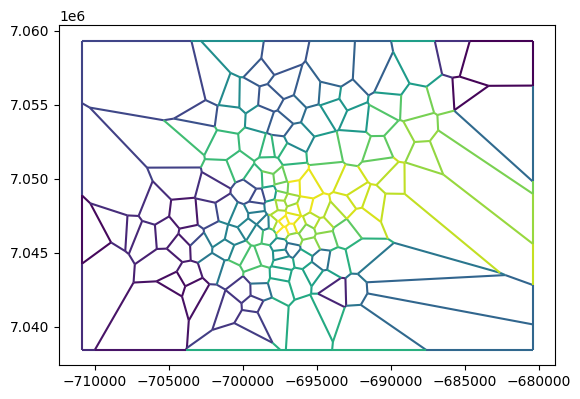

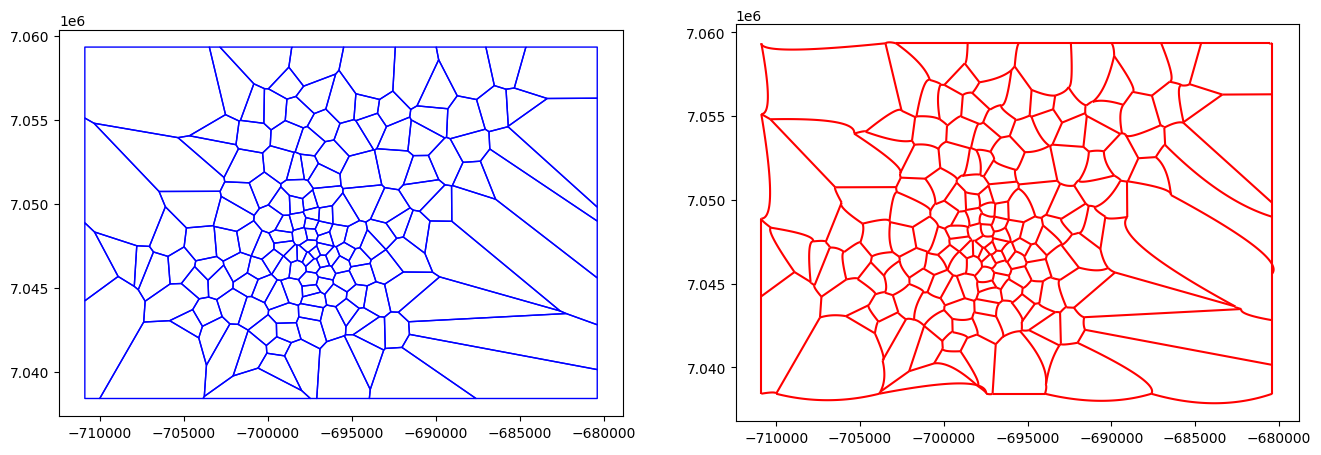

In [15]:
def bez_trouble(multigeom, rel_dist=[0.5,0.5], off_dist=[1,10]):
    # Taking in GeoSeries as input for multigeom    
    multigeom = to_poly(multigeom)

    

    multi_edges = flatten([[LineString(poly.boundary.coords[k:k+2]) for k in range(len(poly.boundary.coords) - 1)] for poly in multigeom])
    
    uni_edges = []
    for edge in multi_edges:
        if not any(e.equals(edge) for e in uni_edges):
            uni_edges.append(edge)

    print("number of unique edges", len(uni_edges))
    gpd.GeoDataFrame(geometry=gpd.GeoSeries(uni_edges)).plot(cmap='viridis')

    print("polygonized unique edges:", len(gpd.GeoSeries(shapely.polygonize(uni_edges).geoms)))
    
    out_list = []

    for edge in uni_edges:
        edge_bez = LineStringBender(edge, random.uniform(rel_dist[0],rel_dist[1]), random.uniform(off_dist[0],off_dist[1]), 'left').smooth_curve_geom()
        out_list.append(edge_bez)

    print(len(out_list))
    print(out_list)

    fig, axs = plt.subplots(1,2, figsize=(16,10))

    poi_vor_n.plot(ax=axs[0], facecolor='none', edgecolor='blue')
    gdf_bez.plot(ax=axs[1], facecolor='none', edgecolor='red')

    #return gpd.GeoSeries(shapely.polygonize(out_list).geoms)
    return gpd.GeoSeries(out_list)


gdf_bez = bez_trouble(poi_vor_n.geometry, rel_dist=[0.5,0.5], off_dist=[500,500]).clip(boundary.geometry[0])



[<LINESTRING (0 0, 0 1)>, <LINESTRING (0 1, 1 1)>, <LINESTRING (1 1, 1 0)>, <LINESTRING (1 0, 0 0)>]


<Axes: >

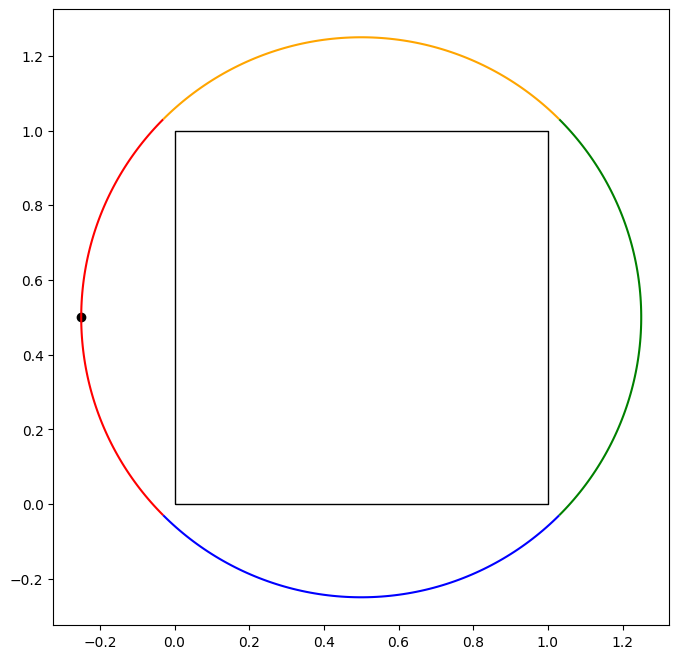

In [16]:
import numpy as np
import shapely.geometry as geom


# draw unit square
square = geom.Polygon([(0,0), (0,1), (1,1), (1,0)])

from shapely.geometry import Polygon, LineString

b = square.boundary.coords
square_bounds = [LineString(b[k:k+2]) for k in range(len(b) - 1)]
print(square_bounds)

def square_arc(square, radius, n):
    # Define the arc (presumably ezdxf uses a similar convention)
    centerx, centery = square.centroid.x, square.centroid.y
    # In degrees
    start_angle = 45 + (90*n)
    end_angle = start_angle + 90
    numsegments = 100

    # The coordinates of the arc
    theta = np.radians(np.linspace(start_angle, end_angle, numsegments))
    x = centerx + radius * np.cos(theta)
    y = centery + radius * np.sin(theta)

    return gpd.GeoSeries(geom.LineString(np.column_stack([x, y])))


fig, ax = plt.subplots(1,1, figsize=(10,8))



radius = 0.75


arc_0 = square_arc(square, radius, 1)
arc_1 = square_arc(square, radius, 2)
arc_2 = square_arc(square, radius, 3)
arc_3 = square_arc(square, radius, 4)

arc_0_mid = arc_0.interpolate(arc_0.length/2, normalized=False)




gpd.GeoSeries(square).plot(ax=ax, edgecolor='black', facecolor='none')
arc_0.plot(ax=ax, color='red')
arc_0_mid.plot(ax=ax, color='black')
arc_1.plot(ax=ax, color='blue')
arc_2.plot(ax=ax, color='green')
arc_3.plot(ax=ax, color='orange')



<Axes: >

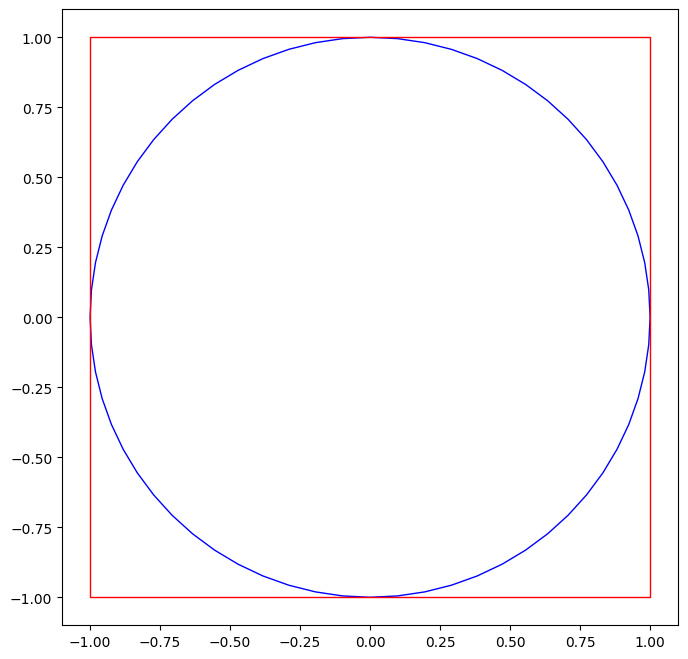

In [17]:
centre = gpd.GeoSeries(Point([0,0]))
circle = centre.buffer(1)
circle_bound = circle.envelope

fig,ax = plt.subplots(1,1,figsize=(10,8))

circle.plot(ax=ax, facecolor='none', edgecolor='blue')
circle_bound.plot(ax=ax, facecolor='none', edgecolor='red')

POINT (0.25 0.25)


<Axes: >

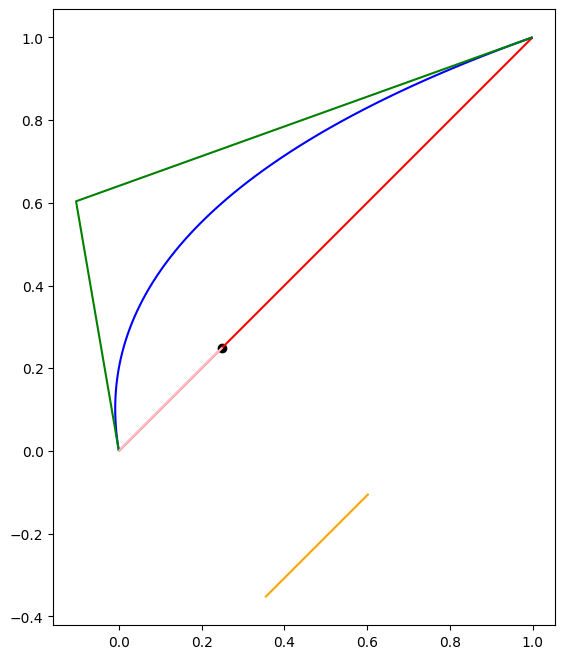

In [18]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely
import os.path
import time

from pathlib import Path
from shapely import voronoi_polygons, MultiPoint, unary_union, LineString
from shapely.ops import nearest_points
from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords

from shapely.wkt import loads

from line_bender import LineStringBender

input_line = loads("LINESTRING(0 0, 1 1)")

#LineStringBender(geometry, relative_distance_along_line, offset_distance_from_line, offset_position)
"""
        :param geometry: LineString shapely geometry
        :type geometry: shapely.geometry.LineString
        :param relative_distance_along_line: relative distance to put the node controller on the line ]0-1]
        :type relative_distance_along_line: float, int
        :param offset_distance_from_line: the offset distance from the line, like a buffer value (meters)
        :type offset_distance_from_line: float, int
        :param offset_distance_from_line: offset position, on the right/left of the line
        :type offset_distance_from_line: str, one of 'right', 'left'
"""
rel_dist = 0.25
offset_dist = 0.5
curve_process = LineStringBender(input_line, rel_dist, offset_dist, 'left')

point_control_on_line = input_line.interpolate(rel_dist, True)

print(curve_process.node_controler_geom())

point_control_line = LineString([
            input_line.coords[0],
            *point_control_on_line.coords[:]
        ])
offset_line = point_control_line.parallel_offset(
            offset_dist,
            'right'
        )

curve_smooth = curve_process.smooth_curve_geom()
curve_raw = curve_process.raw_curve_geom()

fig, ax = plt.subplots(1,1, figsize=(10,8))

gpd.GeoSeries(input_line).plot(ax=ax, color='red')
gpd.GeoSeries(curve_smooth).plot(ax=ax, color='blue')
gpd.GeoSeries(curve_raw).plot(ax=ax, color='green')
gpd.GeoSeries(curve_process.node_controler_geom()).plot(ax=ax, color='black')
gpd.GeoSeries(point_control_line).plot(ax=ax, color='pink')
gpd.GeoSeries(offset_line).plot(ax=ax, color='orange')

In [19]:
import numpy as np
from scipy.special import comb

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals


In [20]:
import bezier

# draw unit square
square = shapely.Polygon([(0,0), (0,1), (1,1), (1,0)])

a = Point([0,0])
b = Point([1,1])

num_points = 3
points = []
for i in range(num_points):
    points.append([random.uniform(a.x, b.x), random.uniform(a.y, b.y)])

print(points)
nodes_gdf = gpd.GeoSeries(gpd.points_from_xy(points[0], points[:,1]))
points = np.transpose(points)

line_ab = LineString([a,b])

nodes = np.asfortranarray(points)

print(nodes)

fig, ax = plt.subplots(1,1,figsize=(10,8))

curve = bezier.Curve(nodes, degree=2)
curve.plot(1000, ax=ax)
gpd.GeoSeries(line_ad).plot(ax=ax, edgecolor='red')
nodes_gdf.plot(ax=ax, color='green')

[[0.6728387140410335, 0.9563663766500681], [0.7690889206673037, 0.5972473871036391], [0.338959480377681, 0.4857277929012559]]


TypeError: list indices must be integers or slices, not tuple

<Axes: >

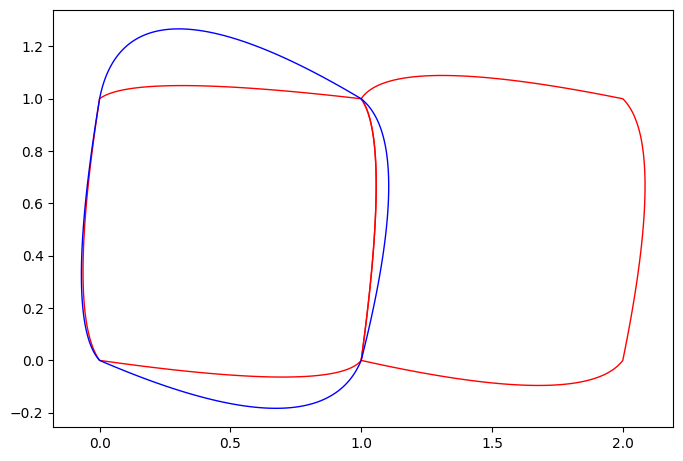

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely
import os.path
import time
import random

from pathlib import Path
from shapely import voronoi_polygons, MultiPoint, unary_union, LineString, Polygon, Point, MultiPolygon
from shapely.ops import nearest_points
from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords

from shapely.wkt import loads

from line_bender import LineStringBender

# draw unit square
square_a = shapely.Polygon([(0,0), (0,1), (1,1), (1,0)])
square_b = shapely.Polygon([(1,0), (1,1), (2,1), (2,0)])

squares = MultiPolygon([square_a, square_b])

def bez_warp(shape, rel_dist=[0.1,1], off_dist=[0.1,1]):
    shape_edges = [LineString(shape.boundary.coords[k:k+2]) for k in range(len(shape.boundary.coords) - 1)]
    out_list = []
    for edge in shape_edges:
        edge_bez = LineStringBender(edge, random.uniform(rel_dist[0],rel_dist[1]), random.uniform(off_dist[0],off_dist[1]), 'left').smooth_curve_geom()
        out_list.append(edge_bez)
    return shapely.polygonize(out_list).geoms

def bez_warp_multi(multishape, rel_dist=[0.1,1], off_dist=[0.1,1]):
    multi_edges = flatten([[LineString(poly.boundary.coords[k:k+2]) for k in range(len(poly.boundary.coords) - 1)] for poly in multishape.geoms])
    
    uni_edges = []
    for edge in multi_edges:
        if not any(e.equals(edge) for e in uni_edges):
            uni_edges.append(edge)

    out_list = []
    for edge in uni_edges:
        edge_bez = LineStringBender(edge, random.uniform(rel_dist[0],rel_dist[1]), random.uniform(off_dist[0],off_dist[1]), 'left').smooth_curve_geom()
        out_list.append(edge_bez)
    return shapely.polygonize(out_list).geoms

def flatten(xss):
    return [x for xs in xss for x in xs]

squares_edges = flatten([[LineString(poly.boundary.coords[k:k+2]) for k in range(len(poly.boundary.coords) - 1)] for poly in squares.geoms])



square_bez = bez_warp(square_a, [0.1,0.2])
squares_bez = bez_warp_multi(squares, [0.1,0.2], [0.1, 0.2])

fig, ax = plt.subplots(1,1,figsize=(8,8))

gpd.GeoSeries(squares_bez).plot(ax=ax, edgecolor='red', facecolor='none')
gpd.GeoSeries(square_bez).plot(ax=ax, edgecolor='blue', facecolor='none')